얼마전 반도체 주식에대한 영상을 유투브를 통해 보았고, 증권사 출신 지인에게 반도체 회사 중 ASML 이라는 회사에 대해 듣게되었다.


어느정도 관심이 생긴 ASML에 대하여 다양한 정보들을 추출해보고 ASML 데이터로 시계열 데이터 분석의 신뢰도도 알아볼 계획이다.

결과가 좋다면 투자도 (소액)해보려한다..

## 순서

- yfinance로 선택한 기업의 재무정보를 보고 기업을 파악한다
- yfinance를 사용해 야후 파이낸스의 주가 차트 데이터를 가져온다
- pandas_datareader 로 가져온 정보를 dataframe화 한다
- fbprophet 으로 시계열 데이터 분석을 한다

## 라이브러리 불러오기

In [1]:
#pip install yfinance
#pip install pandas_datareader
#pip install fbprophet (설치가 꽤 까다롭다 밑에 링크 참고하여 설치)
# https://stackoverflow.com/questions/56701359/running-setup-py-install-for-fbprophet-error

In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
from fbprophet import Prophet
from pandas_datareader import data

## yfinance 가 제공하는 다양한 정보 출력하기

In [3]:
#회사 요약 정보 불러오기
asml_info = yf.Ticker("ASML").info
print(asml_info['longBusinessSummary'])

ASML Holding N.V. develops, produces, markets, sells, and services advanced semiconductor equipment systems consisting of lithography, metrology, and inspection related systems for memory and logic chipmakers. The company provides extreme ultraviolet lithography systems; and deep ultraviolet lithography systems comprising immersion and dry lithography solutions to manufacture various range of semiconductor nodes and technologies. It also offers metrology and inspection systems, including YieldStar optical metrology solutions to measure the quality of patterns on the wafers; and HMI e-beam solutions to locate and analyze individual chip defects. In addition, the company provides computational lithography and software solutions to create applications that enhance the setup of the lithography system; and mature products and services that refurbish used lithography equipment and offers associated services. It operates in Japan, South Korea, Singapore, Taiwan, China, the Netherlands, Europe

In [4]:
#회사 배당, 분할 정보 불러오기
asml_action = yf.Ticker("ASML").actions
print(asml_action)

            Dividends  Stock Splits
Date                               
1997-05-12      0.000      2.000000
1998-05-08      0.000      2.000000
2000-04-17      0.000      3.000000
2007-10-01      2.840      0.888889
2008-04-07      0.371      0.000000
2009-03-30      0.270      0.000000
2010-03-26      0.283      0.000000
2011-04-26      0.539      0.000000
2012-04-30      0.593      0.000000
2012-11-29     11.870      0.000000
2013-04-26      0.706      0.000000
2014-04-25      0.835      0.000000
2015-04-24      0.811      0.000000
2016-05-03      1.145      0.000000
2017-04-28      1.307      0.000000
2018-04-27      1.718      0.000000
2019-04-26      2.386      0.000000
2019-11-04      1.170      0.000000
2020-04-24      1.458      0.000000
2020-11-02      1.396      0.000000
2021-05-03      1.886      0.000000
2021-11-02      2.094      0.000000


In [5]:
#재무제표 출력하기
asml_financial = yf.Ticker("ASML").financials
print(asml_financial)

                                           2021-12-31     2020-12-31  \
Research Development                     2547000000.0   2200800000.0   
Effect Of Accounting Charges                     None           None   
Income Before Tax                        6904600000.0   4105200000.0   
Minority Interest                                None           None   
Net Income                               5883200000.0   3553700000.0   
Selling General Administrative            725600000.0    544900000.0   
Gross Profit                             9809000000.0   6797200000.0   
Ebit                                     6536400000.0   4051500000.0   
Operating Income                         6536400000.0   4051500000.0   
Other Operating Expenses                         None           None   
Interest Expense                          -54600000.0    -43300000.0   
Extraordinary Items                              None           None   
Non Recurring                                    None           

그외에
.major_holders (주주정보)
.institutional_holders (기업 주주 정보)
.balance_sheet (대차 대조표)
.cashflow (현금 흐름표)
.earnings (기업실적)
를 불러올 수 있다.

## 주가 데이터 불러오기

In [6]:
yf.pdr_override()

In [7]:
#임의로 2018년부터 현재시간으로 범위를 설정하였다.
start_date = "2018-01-01"
end_date = datetime.date.today()
asml = data.get_data_yahoo("ASML",start_date, end_date)

#확인
print(asml.head())
print('******************************************************************************************')
print(asml.tail())

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2018-01-02  174.139999  177.839996  173.979996  177.729996  170.893707   
2018-01-03  177.729996  179.580002  177.679993  179.080002  172.191803   
2018-01-04  180.490005  181.770004  179.399994  180.750000  173.797592   
2018-01-05  180.839996  183.449997  180.750000  182.869995  175.836014   
2018-01-08  183.190002  184.460007  182.809998  183.830002  176.759094   

             Volume  
Date                 
2018-01-02   818600  
2018-01-03  1054200  
2018-01-04   915600  
2018-01-05   516100  
2018-01-08   763900  
******************************************************************************************
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-03-01  660.210

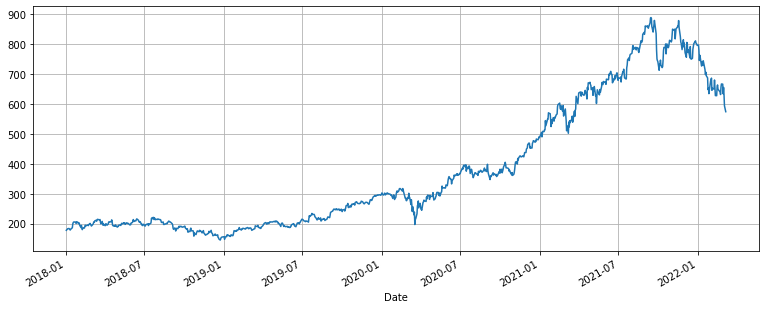

In [8]:
#종가 기준으로 그래프를 출력해봤다
%matplotlib inline
asml["Close"].plot(grid = True, figsize = (13, 5));

## fbprophet을 이용해 시계열 분석하기

In [9]:
# 시계열 데이터 분석을 위해 fbprophet 은 특정한 형식을 요구한다. column 은 'ds', 'y'로 해야한다
asml_trunc = pd.DataFrame({
    "ds":asml.index,
    "y":asml["Close"]
})

#index와 ds가 겹치므로 index 를 reset 해준뒤 Date 칼럼을 삭제한다
asml_trunc.reset_index(inplace=True)
del asml_trunc["Date"]
asml_trunc.head()

,ds,y
0,2018-01-02,177.729996
1,2018-01-03,179.080002
2,2018-01-04,180.750000
3,2018-01-05,182.869995
4,2018-01-08,183.830002


In [10]:
m = Prophet(yearly_seasonality = True, daily_seasonality = True)
m.fit(asml_trunc)
#현재 일로부터 periods 일뒤의 데이터를 예측하라는 것. 60일로 지정하여 진행하였다
future =  m.make_future_dataframe(periods=60)
forecast = m.predict(future)

Initial log joint probability = -12.3129
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2716.57    0.00152732       435.486           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2789.12    0.00831366         256.9           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2811.24    0.00158006       343.958      0.1829           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     364       2817.75   8.71421e-05       206.011   7.294e-07       0.001      466  LS failed, Hessian reset 
     399       2819.49    0.00224409       237.733           1           1      515   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2823.65    0.00266646    

In [11]:
#예측데이터 확인
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-02,188.184314,194.533105,273.482281,188.184314,188.184314,47.540665,47.540665,47.540665,46.851881,...,2.426173,2.426173,2.426173,-1.737389,-1.737389,-1.737389,0.0,0.0,0.0,235.724980
1,2018-01-03,187.995442,196.235388,272.858495,187.995442,187.995442,46.471698,46.471698,46.471698,46.851881,...,2.440989,2.440989,2.440989,-2.821172,-2.821172,-2.821172,0.0,0.0,0.0,234.467140
2,2018-01-04,187.806569,196.114719,274.263040,187.806569,187.806569,45.847958,45.847958,45.847958,46.851881,...,2.971514,2.971514,2.971514,-3.975437,-3.975437,-3.975437,0.0,0.0,0.0,233.654527
3,2018-01-05,187.617697,194.895158,271.782402,187.617697,187.617697,43.770345,43.770345,43.770345,46.851881,...,2.111209,2.111209,2.111209,-5.192746,-5.192746,-5.192746,0.0,0.0,0.0,231.388041
4,2018-01-08,187.051079,186.280395,267.808691,187.051079,187.051079,39.485162,39.485162,39.485162,46.851881,...,1.763085,1.763085,1.763085,-9.129804,-9.129804,-9.129804,0.0,0.0,0.0,226.536241


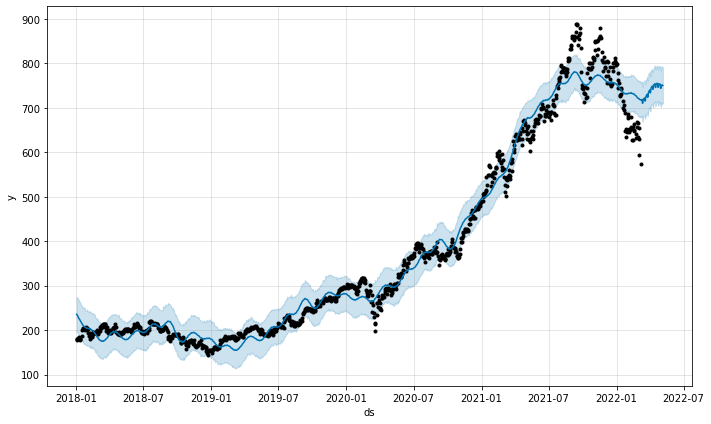

In [12]:
#예측데이터를 시각화해보기
m.plot(forecast[["ds","yhat", "yhat_upper", "yhat_lower"]]);

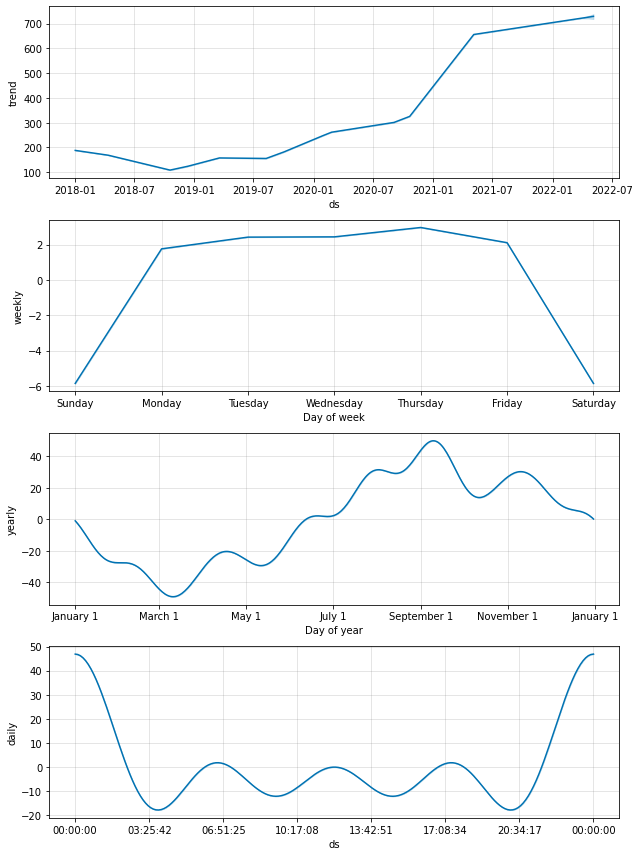

In [13]:
#전체, 주별, 연별, 일별 트렌드 보기
m.plot_components(forecast);

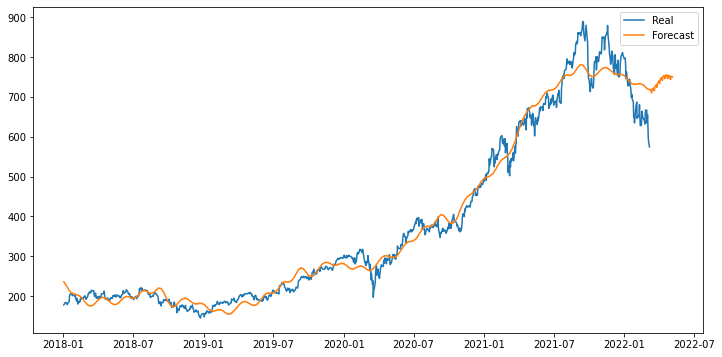

In [14]:
#matplotlib을 사용하여 실제차트와 예측차트의 유사성을 파악
plt.figure(figsize = (12,6))
plt.plot(asml.index, asml["Close"], label = "Real")
plt.plot(forecast["ds"], forecast["yhat"], label = "Forecast")
plt.legend()
plt.show()

큰 거시적 변동이 있을때는 괴리가 큰편이다. 보조지표로 삼는데는 조금더 고려가 필요해보인다;;